In [2]:
import random
from math import cos, sin

import checker
import matplotlib.pyplot as plt
import numpy as np
import utils

## Po co nam to numpy?
Przydaje nam się z kilku powodów:
* Napisanie jednej linijki w numpy jest szybsze i wygodniejsze niż napisanie pętli, jest też mniejsza szansa, że zrobimy gdzieś po drodze błąd. Oczywiście najpierw trzeba się przyzwyczaić do intefejsu.
* Numpy jest znacznie bardziej wydajny niż napisane przez nas funkcje w "czystym" Pythonie.
* PyTorch, biblioteka do głębokiego uczenia, z której później będziemy korzystać, ma bardzo podobny interfejs.

### Kilka przykładów

In [3]:
%%timeit

X = [random.random() for _ in range(10000)]
y = [sin(x) + cos(x) for x in X]

2.6 ms ± 80.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit

X = np.random.random(10000)
y = np.sin(X) + np.cos(X)

183 µs ± 6.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
def almost_variance(x: np.ndarray) -> np.ndarray:
    """Oblicza 1/n * SUM (x_i - mean(x))^4"""
    m = sum(x) / len(x)
    result = 0
    for i in range(len(x)):
        result += (x[i] - m) ** 4
    result /= len(x)
    return result


def numpy_almost_var(x: np.ndarray) -> np.ndarray:
    m = np.mean(x)
    powers = (x - m) ** 4
    return np.mean(powers)


X = np.random.random(10000)

In [6]:
%%timeit
almost_variance(X)

4.46 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit
numpy_almost_var(X)

337 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Zadanie 1. (3 pkt.)
Wykonać poniższe ćwiczenia przy pomocy Numpy:

1. Wykorzystując `broadcasting` (patrz na rysunek poniżej) stwórz funkcję, która dla zadnego $K$ zwraca tabliczkę mnożenia, tzn. tablicę $A$ taką, że: $$A_{ij} = i \cdot j\;\;\;\;\; \forall i,j \in \{1,\dots,K\}$$
    <img src="http://www.astroml.org/_images/fig_broadcast_visual_1.png">

    Przydatne funkcje: `np.arange`, `np.reshape`. 

In [17]:
def multiplication_table(k: int) -> np.ndarray:
    x = np.arange(1,k+1)
    y = np.arange(1,k+1)
    y = np.reshape(y, (-1, 1))
    return x*y


print("Wynik funkcji multiplication:\n", multiplication_table(10))
checker.check_multiplication_table(multiplication_table)

Wynik funkcji multiplication:
 [[  1   2   3   4   5   6   7   8   9  10]
 [  2   4   6   8  10  12  14  16  18  20]
 [  3   6   9  12  15  18  21  24  27  30]
 [  4   8  12  16  20  24  28  32  36  40]
 [  5  10  15  20  25  30  35  40  45  50]
 [  6  12  18  24  30  36  42  48  54  60]
 [  7  14  21  28  35  42  49  56  63  70]
 [  8  16  24  32  40  48  56  64  72  80]
 [  9  18  27  36  45  54  63  72  81  90]
 [ 10  20  30  40  50  60  70  80  90 100]]


2. Mając daną tablice jednowymiarową oraz liczbę `x` znajdź najbliższą wartość `x` w `A`, tzn. 
    $$ \mathrm{closest}(x, A) = \arg\min_{a\in A}|x - a|  $$

    Przydatne funkcje: `np.argmin`, `np.abs`. 

In [39]:
def closest(x: float, A: np.ndarray) -> np.ndarray:
    y = [x-a for a in A]
    z = np.abs(y)
    return A[np.argmin(z)]


print("Wynik funkcji closest:", closest(6, np.array([5, 3, 4])))
checker.check_closest(closest)

Wynik funkcji closest: 5


3. Zaimplementuj proste liczenie wartosci wielomianu o zadanych współczynnikach (analogię `np.poly1d`), czyli funkcję

    $$
    \mathrm{poly}(x, a) = a_0 + a_1 x + a_2 x^2 + \dots + a_k x^k = \sum_{i=1}^k a_i x^i
    $$

    Potencjalnie przydatne funkcje: `np.cumprod`, `np.concatenate`, `np.sum`.

In [67]:
def poly(x: int, a: np.ndarray) -> np.ndarray:
    xs = [x for i in range(1, len(a))]
    xs = np.cumprod(xs)
    a0 = a[0]
    a = a[1:]
    vals = a*xs
    return np.sum(vals) + a0


print("Wynik funkcji poly:", poly(6, np.array([5.5, 3, 4])))
checker.check_poly(poly)

Wynik funkcji poly: 167.5


## Zadanie 2. (2 pkt.)
Dla macierzy $X$ o wymiarze `[N, D]` zaimplementować operację whiteningu: 

$\mathrm{whiten}(X) = (X-\mathrm{mean} X)(\mathrm{cov} X)^{-1/2}$

$\mathrm{mean} X$ rozumiemy jako wektor wierszowy, którego każdy element jest zdefiniowany jako: $$(\mathrm{mean}X)_i = \frac{1}{N} \sum_{j=1}^N X_{ij}$$

**Uwaga 1: np.cov przyjmuje, że każdy wiersz macierzy to osobna cecha, a każda kolumna to osobna obserwacja - czyli odwrotnie niż u nas. Dlatego przed podaniem naszej macierzy do np.cov trzeba ją transponować.**

**Uwaga 2: pierwiastek z macierzy to nie to samo co pierwiastkowanie element-wise, takie jak w np.sqrt. Najlepiej poszukać odpowiedniej funkcji w bibliotece scipy i ją zaimportować.**

In [161]:
from numpy.linalg import matrix_power
from scipy.linalg import sqrtm



def whiten(X: np.ndarray) -> np.ndarray:
    meanX = np.mean(X, axis=0)
    meanX = meanX.T
    covX = np.cov(X,rowvar=False)
    covX = matrix_power(covX, -1)
    covX = sqrtm(covX)
    print(covX)

    return (X-meanX)@covX
    
    
    
# whiten(np.array([[-1,3,1],[1,2,1002]]))

[[ 3.16135283e-01 -1.04392920e-03]
 [-1.04392920e-03  1.50971536e+00]]


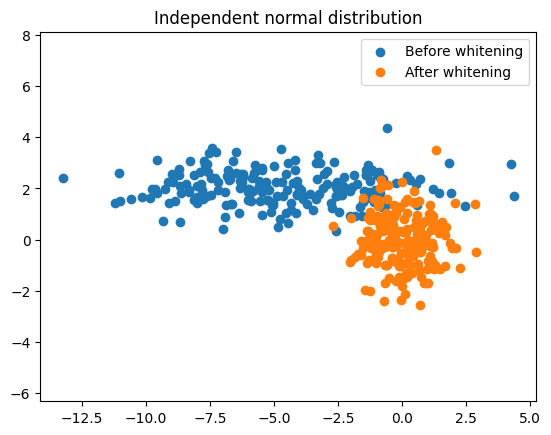

[[ 5.21510795 -4.49674423]
 [-4.49674423  5.23313215]]


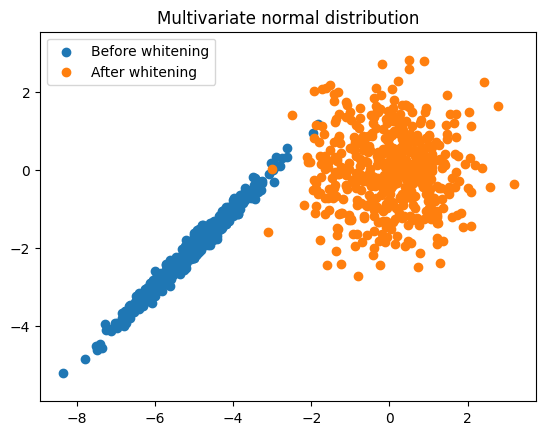

[[0.19223362 0.00639037]
 [0.00639037 0.20054452]]


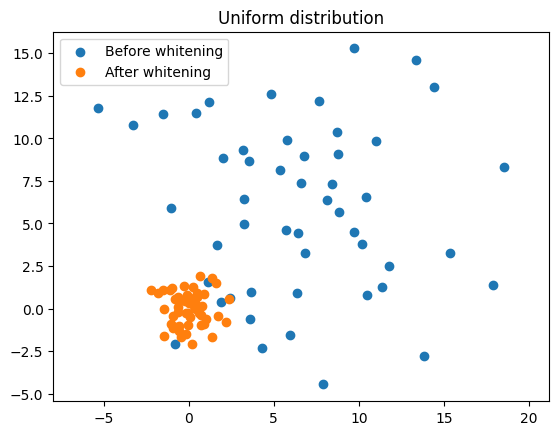

[[ 0.54325674 -0.06331151]
 [-0.06331151  0.49842571]]


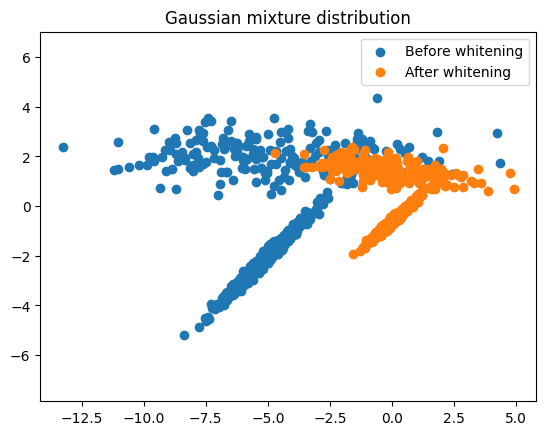

In [162]:
X_diag_normal = np.random.multivariate_normal([-5, 2.0], [[10, 0], [0, 0.5]], size=200)
X_multivariate_normal = np.random.multivariate_normal([-5, -2], [[1, 0.99], [0.99, 1]], size=500)
X_uniform = np.random.normal(6, 5, size=(50, 2))
X_gmm = np.concatenate((X_multivariate_normal, X_diag_normal), axis=0)

utils.scatter_with_whiten(X_diag_normal, whiten, name="Independent normal distribution")
utils.scatter_with_whiten(X_multivariate_normal, whiten, name="Multivariate normal distribution")
utils.scatter_with_whiten(X_uniform, whiten, name="Uniform distribution")
utils.scatter_with_whiten(X_gmm, whiten, name="Gaussian mixture distribution")

## Standaryzacja a whitening
W pierwszym notebooku implementowaliśmy następującą funkcję, która wykonuje zadanie podobne do whiteningu:

$$ f(x_{ij}) = \frac{x_{ij} - \mu_j}{\sigma_j} $$

Tę funkcję nazwijmy **standaryzacją**. Czym zatem różni się standaryzacja od whiteningu? Czy nie wystarczy znormalizować kolumn i zamiast tego musimy wykonywać znacznie bardziej kosztowną operację liczenia i odwracania macierzy kowariancji?

[[ 3.16135283e-01 -1.04392920e-03]
 [-1.04392920e-03  1.50971536e+00]]


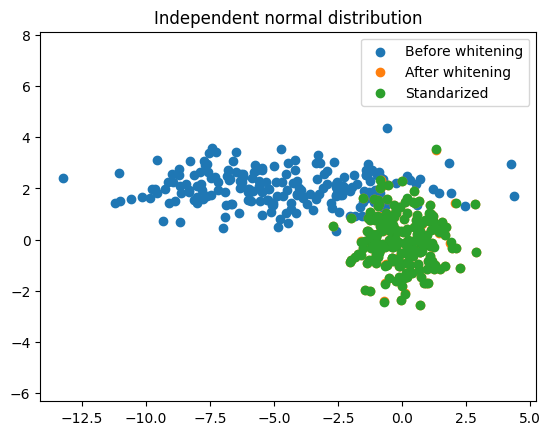

[[ 5.21510795 -4.49674423]
 [-4.49674423  5.23313215]]


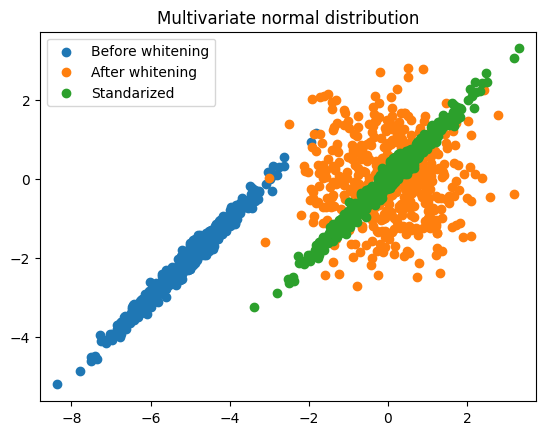

[[0.19223362 0.00639037]
 [0.00639037 0.20054452]]


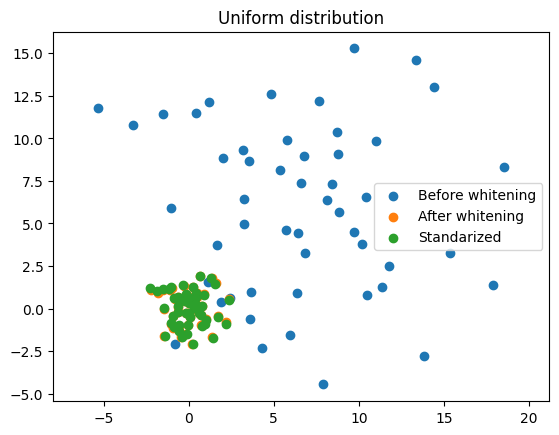

[[ 0.54325674 -0.06331151]
 [-0.06331151  0.49842571]]


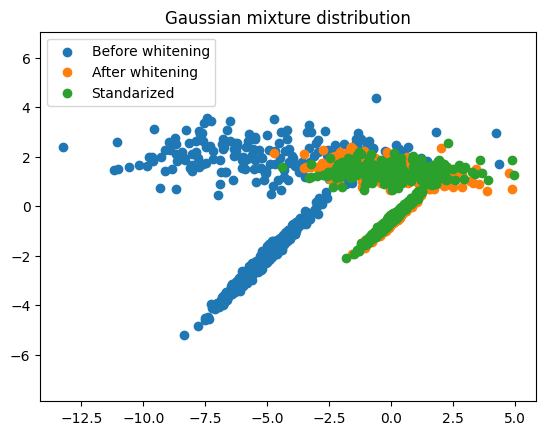

In [163]:
utils.scatter_with_whiten(
    X_diag_normal, whiten, name="Independent normal distribution", standarize=True
)
utils.scatter_with_whiten(
    X_multivariate_normal, whiten, name="Multivariate normal distribution", standarize=True
)
utils.scatter_with_whiten(X_uniform, whiten, name="Uniform distribution", standarize=True)
utils.scatter_with_whiten(X_gmm, whiten, name="Gaussian mixture distribution", standarize=True)

## Zadanie 3. (2 pkt.)
Należy:
1. Wysamplować $10000$ przykładów z rozkładu normalnego $\mathcal{N}(\mu, \sigma)$. **Należy wybrać niestandardowe parametry**, tzn. $\mu \neq 0$ oraz $\sigma \neq 1$.
2. Następnie należy policzyć, jaki procent wylosowanych przykładów, znajduje się od środka w odległości większej niż: 
    * $1\sigma$ (tzn. $|x - \mu| > 1\sigma$)
    * $2\sigma$ (tzn. $|x - \mu| > 2\sigma$)
    * $3\sigma$ (tzn. $|x - \mu| > 3\sigma$)
    
3. Wypisać wszystkie przykłady, które wpadają do ostatniej kategorii (tzn. są oddalone o co najmniej $3\sigma$ od średniej).

[-7.06664998 -7.04857106]


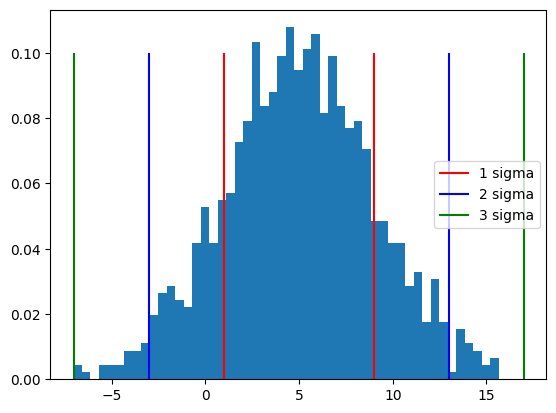

In [179]:
# Podpunkt 1: Wysamplować 10000 przykładów z rozkładu normalnego
loc = 5  # średnia wybranego rozkładu normalnego
scale = 4  # odchylenie standardowe wybranego rozkładu normalnego
X = np.random.normal(loc, scale, 1000)

# Podpunkt 2: Wyliczyć i wypisać procent 
p1 = len(X[np.abs(X-loc) > scale])/len(X)
p2 = len(X[np.abs(X-loc) > 2*scale])/len(X)
p3 = len(X[np.abs(X-loc) > 3*scale])/len(X)


# Podpunkt 3: Wypisać elementy, które są oddalone od średniej o 3 sigma.
print(X[np.abs(X-loc) >=  3*scale])

# Trochę wizualizacji
utils.visualize_normal_dist(X, loc, scale)